# MTH 651: Advanced Numerical Analysis

## Lecture 7

### Topics

* Construction of Finite Element Spaces

#### Textbook references

Sections 3.1, 3.2, 3.3

We have spent the past few lectures building up the theory of Sobolev spaces and Hilbert spaces, allowing us to define the "abstract" Galerkin method, given as follows.
Let $H$ be a Hilbert space, and let $S \subseteq H$ be a subspace.
Let $a(\cdot, \cdot)$ be a continuous symmetric bilinear form on $H$ that is coercive on $S$.
Then, the variational problem is

> Given $F \in S'$, find $u_S \in S$ such that 
> $$ a(u_S, v) = F'(u_S) $$
> for all $v \in S$.

This problem is well-posed because $a(\cdot, \cdot)$ defines an inner product on $S$, and so we can apply the Riesz Representation Theorem.

One of the main ideas of the finite element way is the *systematic construction* of finite-dimensional subspaces $S \subseteq H$.

In the finite element method, the main way that we will create these finite dimensional subspaces is by using **piecewise polynomials** defined on a **mesh**.

A **mesh** is a subdivision of a domain into non-overlapping "elements". Each element is one of a small number of geometric primitives.

For example, a **triangular mesh** is a decomposition of a domain $\Omega \subseteq \mathbb{R}^2$ into a collection of triangles, arranged such that no vertex of a triangle lies in the interior of an edge of any other triangle.

There exist a range of techniques for generating these meshes given a description of the geometry.
This is an entire field known as mesh generation.

For some examples, see:

* [Gmsh](https://gmsh.info)
* [DistMesh](http://persson.berkeley.edu/distmesh/)
* [Wikipedia article on mesh generation](https://en.wikipedia.org/wiki/Mesh_generation)
* [Wikipedia article on Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation)



Clearly, we can define piecewise polynomial spaces on such meshes.
Such spaces are going to be the main way that we define finite dimensional subspaces for use in the finite element method.

There are a couple issues that need to be sorted out before we get a practical method.

First, we need a basis for the piecewise polynomial space in order to obtain an algebraic system of equations.

Second, we are interested in working in subspaces of Sobolev spaces (in particular, we will work in subspaces of $H^1(\Omega)$), and so we need to make sure that the piecewise polynomial spaces are indeed a subspace

> _Note:_ for *arbitrary* piecewise polynomials defined on a mesh, the space is *not* a subspace of $H^1$: if there are no continuity requirements enforced at element interfaces, then the functions can have discontinuities along edges, and will not have well-defined weak derivatives.
> Such methods are sometimes used, and are called _discontinuous Galerkin_ methods, but for now we will focus on methods using subspaces of $H^1$.

Recall from the one-dimensional example, we used the space of piecewise linear functions spanned by the "hat" basis functions.

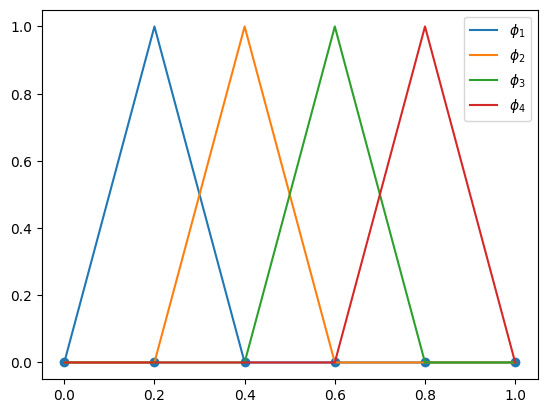

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 4
x = np.linspace(0, 1, n+2)

def phi(i):
   y = np.zeros(n+2)
   y[i] = 1
   return y

plt.scatter(x, 0*x)
plt.plot(x, phi(1), label="$\\phi_1$")
plt.plot(x, phi(2), label="$\\phi_2$")
plt.plot(x, phi(3), label="$\\phi_3$")
plt.plot(x, phi(4), label="$\\phi_4$")
plt.legend()
plt.show()

Now we are interested in creating similar spaces, but defined on more general regions (in particular, in domains in $\mathbb{R}^2$ and $\mathbb{R}^3$ rather than just on intervals on the real line).

### Definition of a "Finite Element"

> **_DEFINITION:_** Let
> 
> 1. $K \subseteq \mathbb{R}^n$ be a bounded closed set with nonempty interior and piecewise smooth boundary. ($K$ is called the **element domain**)
> 2. $\mathcal{P}$ be a finite-dimensional space of functions $K \to \mathbb{R}$ (called the space of **shape functions**)
> 3. $\mathcal{N} = \{ N_1, N_2, \ldots, N_k \}$ be a basis for $\mathcal{P}'$ (the **nodal variables**)
>
> The triple $(K, \mathcal{P}, \mathcal{N})$ is called a **finite element**

Each **nodal variable** $N_i$ defines a shape function $\phi_i$ given by
$$
    N_j(\phi_i) = \delta_{ij}
$$

Therefore, the set of functions
$$
    \{ \phi_1, \phi_2, \ldots, \phi_k \}
$$
defines a basis for $\mathcal{P}$.
This basis is called the **nodal basis**.

How does this definition of a finite element relate to the 1D finite elements we saw in the previous lectures?

Let

* $K = [0,1]$
* $\mathcal{P}$ be the space of linear polynomials $[0,1] \to \mathbb{R}$
* $\mathcal{N} = \{ N_1, N_2 \}$, where
    * $N_1(v) = v(0)$
    * $N_2(v) = v(1)$

This defines a finite element (the **nodes** are the two endpoints), and the **nodal basis** of $\mathcal{P}$ is given by

* $\phi_1(x) = 1 - x$
* $\phi_2(x) = x$

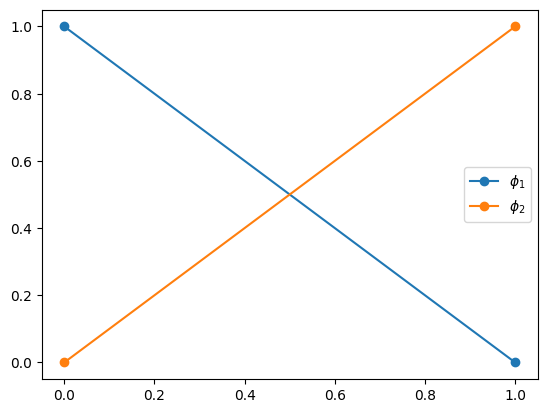

In [2]:
x = np.array([0, 1])

plt.plot(x, 1 - x, label="$\\phi_1$", marker="o")
plt.plot(x, x, label="$\\phi_2$", marker="o")
plt.legend()
plt.show()

More generally, we can consider all polynomials of degree up to $k$.

This is often referred to as a "high-order" finite element.

Let

* $K = [0,1]$ (or we could take any interval $[a,b]$)
* $\mathcal{P}$ the space of polynomials of degree no more than $k$
* $\mathcal{N} = \{ N_0, N_1, \ldots, N_k \}$, where $N_i(u) = u(x_i)$, where the points $\{ x_i \}$ are distinct

The main thing we will need to check is check is condition 3, that the nodal variables $\{ N_i \}$ form a basis for $\mathcal{P}'$.

This is made easier using the following proposition.

> **_PROPOSITION:_** Let $\mathcal{P}$ be a $d$-dimensional vector space, and let $\{ N_1, N_2, \ldots, N_d \}$ be a subset of $\mathcal{P}'$.
> Then, the following are equivalent.
>
> 1. $\{ N_1, N_2, \ldots, N_d \}$ is a basis for $\mathcal{P}'$
> 2. Given $v \in \mathcal{P}$, $N_i(v) = 0$ for all $i$ implies that $v = 0$.

> _Proof._ 
>
> First we prove that statement 1 implies statement 2.
> We begin with the claim that if $L v = 0$ for all linear functionals $L$, then $v = 0$.
> Note that $L_v : u \mapsto (v, u)$ is a linear functional, and so $L_v(v) = (v, v)$, and so $L_v(v) = 0$ implies that $v = 0$, proving the claim.
> Assuming statement 1, any $L \in \mathcal{P}'$ can be written as $L = \sum_{i=1}^d a_i N_i$.
> Then, if $N_i(v) = 0$ for all $i$, we have $L(v) = \sum_{i=1}^d a_i N_i (v) = 0$, implying (by the claim) that $v = 0$, showing that statement 2 holds.
>
> We now prove that the negation of statement 1 implies the negation of statement 2.
> Suppose that $\{ N_i \}$ is not a basis.
> This means that $\{ N_i \}$ cannot span $\mathcal{P}'$.
> For each $N_i$, there exists $u_i \in \mathcal{P}$ such that $N_i(v) = (u_i, v)$ for all $v$.
> We see that $\{ u_i \}$ cannot span $\mathcal{P}$ (otherwise $\{N_i\}$ would span $\mathcal{P}'$).
> Consequently, $\operatorname{span}\{ u_i \}^\perp$ is nontrivial, so we can choose some $0 \neq w \in \mathcal{P}$ such that $(u_i, w) = 0$.
> Consequently, $N_i(w) = 0$, proving the negation of statement 2.

We will use this proposition to verify that the nodal variables above form a basis for $\mathcal{P}'$.
Let $u$ be an arbitrary polynomial of degree at most $k$.
Suppose $N_i(u) = 0$ for all $i$.
Then, $u$ has $k+1$ distinct zeros, which (by the fundamental theorem of algebra) implies that $u \equiv 0$.
Therefore, the second statement of the proposition holds, and so $\{ N_i \}$ is a basis, verifying that the "high-order" finite element really satisfies the definitions of a finite element.

> **_LEMMA:_**
> Let $P$ be a polynomial of degree $d \geq 1$.
> Suppose $P$ vanishes on the hyperplane $\{ x : L(x) = 0 \}$.
> Then, $P(x) = L(x) Q(x)$, where $Q$ is a polynomial of degree $d - 1$.

> _Proof._ 
> Change coordinates such that $L(x_1, x_2, \ldots, x_n ) = x_n$, and so the hyperplane $L(x_1, \ldots, x_n) = 0$ is the hyperplane perpendicular to the $x_n$-axis.
>
> Since $\deg(P) = d$, we can write
> $$ P(\hat{x}, x_n) = \sum_{j=0}^d \sum_{|\hat{i}| \leq d - j} c_{\hat{i}j} \hat{x}^{\hat{i}} x_n^j $$
> where $\hat{x} = (x_1, x_2, \ldots, x_{n-1})$ and $\hat{i}$ is a multi-index.
>
> Since $P$ vanishes on the hyperplane $L(\hat{x}, x_n) = 0$, we have that $P(\hat{x}, 0) = 0$.
> Therefore,
> $$
>   0 = P(\hat{x}, 0) = \sum_{|\hat{i}| \leq d} c_{\hat{i}0} \hat{x}^{\hat{i}},
> $$
> and so $c_{\hat{i}0} = 0$ for $|\hat{i}| \leq d$.
> Therefore,
> $$
>   \begin{aligned}
>       P(\hat{x}, x_n)
>       &= \sum_{j=0}^d \sum_{|\hat{i}| \leq d - j} c_{\hat{i}j} \hat{x}^{\hat{i}} x_n^j \\
>       &= \sum_{j=1}^d \sum_{|\hat{i}| \leq d - j} c_{\hat{i}j} \hat{x}^{\hat{i}} x_n^j \\
>       &= x_n \sum_{j=1}^d \sum_{|\hat{i}| \leq d - j} c_{\hat{i}j} \hat{x}^{\hat{i}} x_n^{j-1} \\
>       &= x_n Q = L Q
>   \end{aligned}
> $$
> for appropriately defined $Q$ with $\deg(Q) = d - 1$.

#### Triangular finite elements

Let $K$ be a triangle.
Let $\mathcal{P}_k$ be the set of bivariate polynomials (polynomials of two variables) of total degree $\leq k$.
The dimension of this space is
$$
    \dim(\mathcal{P}) = \binom{k+2}{2} = \frac{1}{2} (k+1) (k+2)
$$
(the argument follows from "dots and dividers")

##### The linear triangular element

Consider a triangle with vertices $v_1, v_2, v_3$ and edges $e_1, e_2, e_3$.
The edge $e_i$ is opposite the vertex $v_i$.


In [3]:
%load_ext tikzmagic

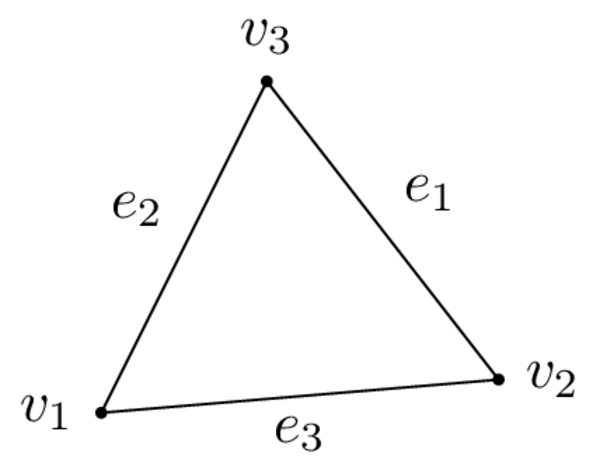

In [4]:
%%tikz -sc 2 -s 600,600
\coordinate (A) at (0,0);
\coordinate (B) at (1.2,0.1);
\coordinate (C) at (0.5,1);

\draw (A) -- (B) node[midway,below] {$e_3$};
\draw (B) -- (C) node[midway,above right] {$e_1$};
\draw (C) -- (A) node[midway,above left] {$e_2$};

\tikzset{dot/.style={circle,inner sep=0pt, minimum size=2pt, fill=black}}

\node [dot, label=left:{$v_1$}] at (A) {};
\node [dot, label=right:{$v_2$}] at (B) {};
\node [dot, label=above:{$v_3$}] at (C) {};

We define the **nodal variables** to simply represent evaluation at the vertices, i.e. let $N_i(u) = u(v_i)$.

To prove that this is a basis for $\mathcal{P}'$, we show that if $N_i(u) = 0$ for all $i$ then $u = 0$.
Suppose $N_i(u) = 0$, so $u$ vanishes at all vertices of the triangle $K$.
Then, since $u$ is linear, $u$ vanishes on all three edges $e_i$.
The edges $e_i$ are hyperplanes that can be written as the set $\{ L_i(x) = 0 \}$.
Applying the lemma, we have that $u(x) = L_i(x) Q(x) = c L_i(x)$ (since $Q(x)$ is a degree-0 polynomial).
Since the zero set of $L_i$ defines the edge $e_i$, we have $L_i(v_i) \neq 0$, so
$$
    u(v_i) = c L(v_i) \qquad \text{and} \qquad u(v_i) = 0
$$
so $c = 0$, and therefore $u \equiv 0$.

##### The quadratic triangular element

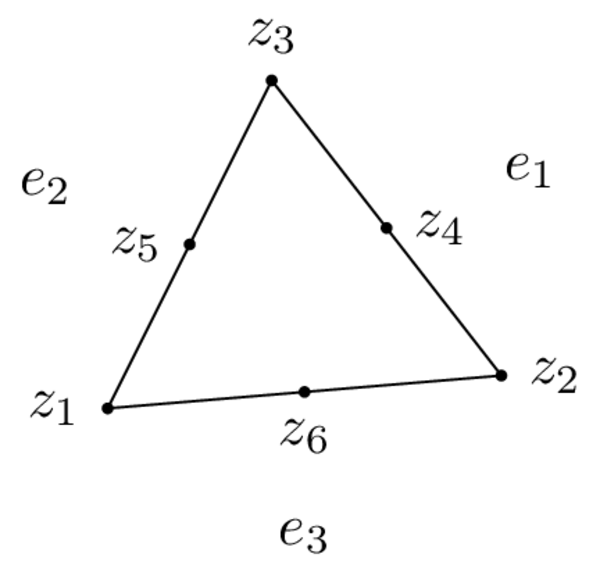

In [5]:
%%tikz -sc 2 -s 600,600
\coordinate (A) at (0,0);
\coordinate (B) at (1.2,0.1);
\coordinate (C) at (0.5,1);

\tikzset{dot/.style={circle,inner sep=0pt, minimum size=2pt, fill=black}}

\draw (A) -- (B) node[midway, dot, label=below:{$z_6$}] {} node[midway,yshift=-25pt] {$e_3$};
\draw (B) -- (C) node[midway, dot, label=right:{$z_4$}] {} node[midway,yshift=10pt,xshift=25pt] {$e_1$};
\draw (C) -- (A) node[midway, dot, label=left:{$z_5$}] {} node[midway,yshift=10pt,xshift=-25pt] {$e_2$};

\node [dot, label=left:{$z_1$}] at (A) {};
\node [dot, label=right:{$z_2$}] at (B) {};
\node [dot, label=above:{$z_3$}] at (C) {};

In this case, there are six nodal variables (six degrees of freedom), representing point values at the vertices and the midpoints of each edge.
We prove that this is a basis for $\mathcal{P}_2$.

Let $u$ vanish at all vertices and midpoints.
Since $u$ is quadratic, $u$ vanishes along each edge $e_i$.
Applying the argument above to each of the edges (the edge $e_i$ is a hyperplanes corresponding to the zero set of $L_i$), we can write $u$ as
$$
    u(x) = L_1(x) Q(x)
$$
where $Q(x)$ is degree-1.
Since $L_1$ is nonzero on edge $e_2$ (except perhaps at the vertex), we know that $Q(x)$ must vanish on edge $e_2$, and so
$$
    Q(x) = c L_2(x)
$$
for some constant $c$.
Therefore,
$$
    u(x) = c L_1(x) L_2(x).
$$
Since $u$ vanishes at the point $z_6$, but $L_1(z_6) \neq 0$ and $L_2(z_6) \neq 0$ we have $c = 0$ and $u \equiv 0$.

##### The cubic triangular element

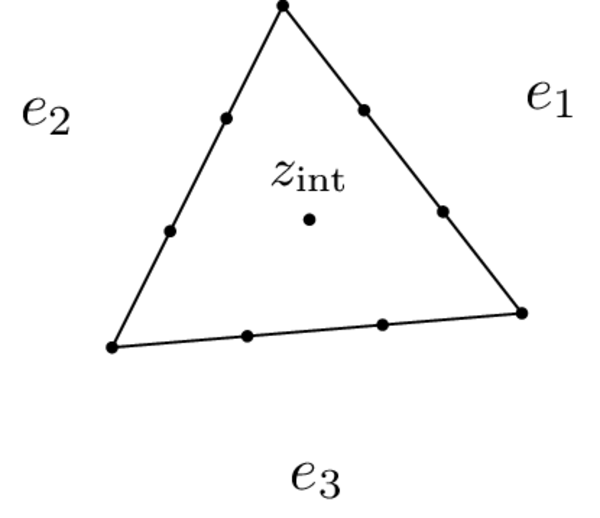

In [6]:
%%tikz -sc 2 -s 600,600

\usetikzlibrary{calc}


\coordinate (A) at (0,0);
\coordinate (B) at (1.2,0.1);
\coordinate (C) at (0.5,1);

\tikzset{dot/.style={circle,inner sep=0pt, minimum size=2pt, fill=black}}

\draw (A) -- (B)
    node[pos=0.33,dot] {}
    node[midway,yshift=-25pt] {$e_3$}
    node[pos=0.66,dot] {};
\draw (B) -- (C)
    node[pos=0.33,dot] {}
    node[midway,yshift=10pt,xshift=25pt] {$e_1$}
    node[pos=0.66,dot] {};
\draw (C) -- (A)
    node[pos=0.33,dot] {}
    node[midway,yshift=10pt,xshift=-25pt] {$e_2$}
    node[pos=0.66,dot] {};

\node [dot,label={\small $z_{\mathrm{int}}$}] at ($(A)!0.66!(0,0) + (B)!0.66!(0,0) + (C)!0.66!(0,0)$) {};

\node [dot] at (A) {};
\node [dot] at (B) {};
\node [dot] at (C) {};

Repeating the arguments from before, taking $u$ that vanishes at all of the nodes, we have that
$$
    u(x) = c L_1(x) L_2(x) L_3(x),
$$
but $L_i(z_{\mathrm{int}}) \neq 0$ and $u(z_{\mathrm{int}}) = 0$, so $c = 0$ and $u \equiv 0$.

In general, for the "higher-order" triangular elements, we have the space $\mathcal{P}_k$ of polynomials of degree at most $k$, and the nodal points:

* $3$ vertex nodes
* $3 (k-1)$ edge nodes ($k-1$ nodes per edge)
* $\frac{1}{2} (k-2) (k-1)$ interior nodes

We can choose the interior nodes to determine the space $\mathcal{P}_{k-3}$ (inductively).

### Finite element spaces

Having now given some examples finite elements, we want to glue them together to create (finite dimensional) subspaces of Sobolev spaces on which we can formulate the Galerkin approximation.
The first ingredient is the **local interpolant**.

> **_DEFINITION:_** 
> Let $(K, \mathcal{P}, \mathcal{N})$ be a finite element.
> Let $\{ \phi_i \}$ be a basis dual to $\mathcal{N}$.
> For a function $v$ (for which $N_i$ are all well-defined), the **local interpolant** of $v$ is
> $$
>   \mathcal{I}_K v = \sum_{i=1}^k N_i(v) \phi_i
> $$

In the case of the triangular elements defined above, the local interpolant is the unique polynomial defined on $K$ that **interpolates** (matches) the values of $v$ at the nodal points.

The following are some properties of the interpolant.

> **_PROPOSITION:_** $\mathcal{I}_K$ is linear.

> _Proof._ Exercise.

> **_PROPOSITION:_** $N_i(\mathcal{I}_K v) = N_i(v)$ for all $i$.

> _Proof._
> $$
>   \begin{aligned}
>       N_i(\mathcal{I}_K(v))
>           &= N_i \left( \sum_{j=1}^k N_j(v) \phi_j \right) \\
>           &= \left( \sum_{j=1}^k N_j(v) N_i(\phi_j) \right) \\
>           &= \left( \sum_{j=1}^k N_j(v) \delta_{ij} \right) \\
>           &= N_i(v)
>   \end{aligned}
> $$

> **_PROPOSITION:_** $\mathcal{I}_K(f) = f$ for any $f \in \mathcal{P}$.
> In particular, $\mathcal{I}_K$ is idempotent (i.e. a projection, $\mathcal{I}_K^2 = \mathcal{I}_K$).

> _Proof._ It holds that
> $$
>   N_i(f - \mathcal{I}_K(f)) = 0.
> $$
> Since $\{ N_i \}$ is a basis for $\mathcal{P}'$ we have that $0 = f - \mathcal{I}_K \in \mathcal{P}$ (by the previous lemma).
> The second statement is a consequence of the first.

Now, we try to piece together the elements and the local interpolants to obtain a global space and global interpolant.
We do this using a mesh.

> **_DEFINITION:_** A **subdivision** of a domain $\Omega$ is a finite collection of element domains $\{ K_i \}$ such that
>
> * $\operatorname{int} K_i \cap \operatorname{int} K_j = \varnothing$ if $i \neq j$
> * $\bigcup_i K_i = \overline{\Omega}$

> **_DEFINITION:_**
> Let $\Omega$ be a domain and let $\mathcal{T}$ be a subdivision.
> Assume each element domain $K \in \mathcal{T}$ is equipped with a space of shape functions and nodal variables such that $(K, \mathcal{P}, \mathcal{N})$ is a finite element.
> Let $f$ be a function for which the nodal variables are all defined (for our purposes, $f \in C^0(\overline{\Omega})$).
> Then, the **global interpolant** of $f$ is defined by
> $$
>   \mathcal{I}_{\mathcal{T}} f|_{K_i} = \mathcal{I}_{K_i} f
> $$
> for all $K_i \in \mathcal{T}$.
> In other words, the global interpolant is defined by piecing together the local interpolants.

Without any further assumptions, we cannot claim any continuity/regularity of the global interpolant.

Now, we make the further assumption on the decomposition, which we will call a **valid triangulation**:

* Each element domain $K_i$ is a triangle
* No vertex of any triangle lies in the interior of any other triangle's edge

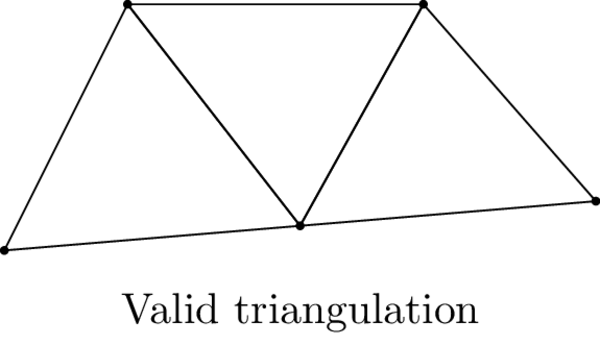

In [7]:
%%tikz -sc 2 -s 600,600

\usetikzlibrary{calc}


\coordinate (A) at (0,0);
\coordinate (B) at (1.2,0.1);
\coordinate (C) at (0.5,1);
\coordinate (D) at (1.7, 1);
\coordinate (E) at (2.4, 0.2);

\tikzset{dot/.style={circle,inner sep=0pt, minimum size=2pt, fill=black}}

\draw (A) -- (B) -- (C) -- cycle;
\draw (B) -- (D) -- (C) -- cycle;
\draw (B) -- (E) -- (D) -- cycle;

\foreach \COORD in {(A), (B), (C), (D), (E)}
    \node [dot] at \COORD {};

\node [yshift=-20pt] at (B) {Valid triangulation};


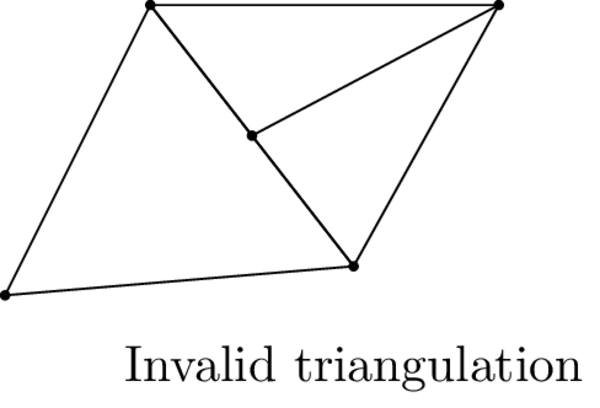

In [8]:
%%tikz -sc 2 -s 600,600

\usetikzlibrary{calc}

\coordinate (A) at (0,0);
\coordinate (B) at (1.2,0.1);
\coordinate (C) at (0.5,1);
\coordinate (D) at (1.7, 1);
\coordinate (E) at ($(B)!0.5!(C)$);

\tikzset{dot/.style={circle,inner sep=0pt, minimum size=2pt, fill=black}}

\draw (A) -- (B) -- (C) -- cycle;
\draw (B) -- (D) -- (C) -- cycle;
\draw (E) -- (D);

\foreach \COORD in {(A), (B), (C), (D), (E)}
    \node [dot] at \COORD {};

\node [yshift=-20pt] at (B) {Invalid triangulation};


> **_PROPOSITION:_** The Lagrange elements defined on valid triangulations are $C^0$ elements, meaning that for any $f \in C^0(\overline{\Omega})$, the global interpolant $\mathcal{I}_{\mathcal{T}}f \in C^0(\overline{\Omega})$.

> _Proof._ Verify continuity along matching triangle edges.